# Nahid-1/Safir launch failure of September 29, 2019

After the Nahid-1/Safir launch failure of September 29, 2019, Donald Trump released this overhead image of the launch site.

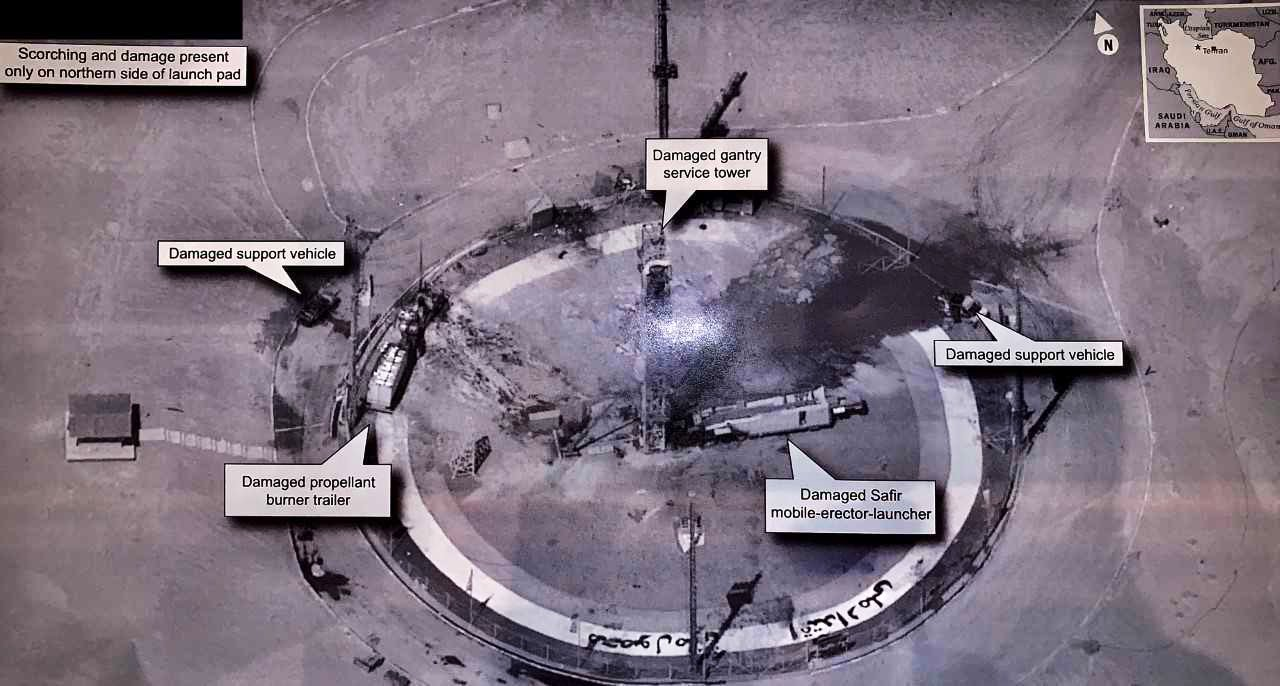

The launch site is [El Khomeini Spaceport](https://en.wikipedia.org/wiki/Imam_Khomeini_Spaceport), located at 35.238 deg North, 53.9508 deg East.

The image shows four masts around a circular launch platform. From Google Earth, the North and South masts are located along a line which has an azimuth of around 192 degrees.

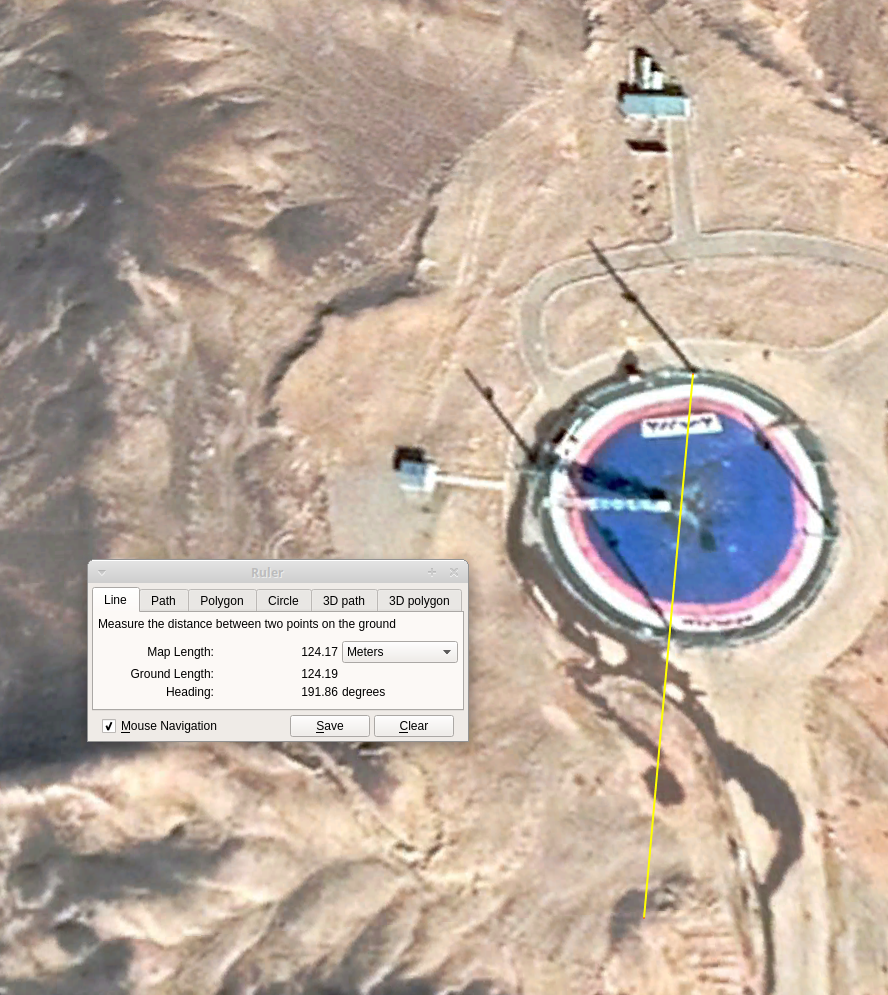

The azimuth of the camera can be estimated from the angle between the towers. Under the assumption that the launch platform is indeed circular, the elevation of the camera can be estimated.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ephem
import datetime
import time

In [2]:
img = plt.imread("twitter_image.jpg")

In [3]:
def create_ellipse(x0, y0, a, b):
    phi = np.linspace(0.0, 2.0*np.pi)
    x, y = a*np.cos(phi)+x0, b*np.sin(phi)+y0
    return x, y

The following values describe an ellipse whose outline matches one of the circles of the launch pad.

In [4]:
x0, y0 = 680, 438
a, b = 270.0, 195.0

The following values define the location of the South tower, and the direction of the North tower and its shadow.

In [5]:
x_south, y_south = 693, 674
x_north_shadow = np.array([742, 705])
y_north_shadow = np.array([74, 135])
x_north_tower = np.array([662, 662])
y_north_tower = np.array([4, 135])
x_north, y_north = 662, 202

In [6]:
def linear_extrapolate(x, y, frac):
    x0, y0 = x[0], y[0]
    dx, dy = x[1]-x[0], y[1]-y[0]
    return x0+frac*dx, y0+frac*dy

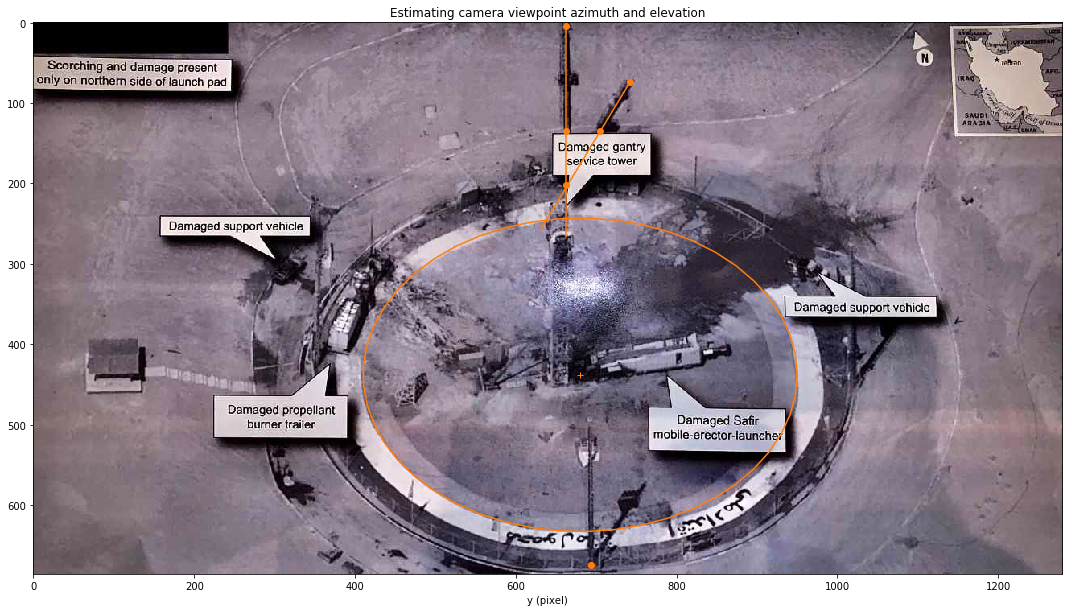

In [7]:
fig, ax = plt.subplots(figsize=(15, 10))

# Plot the image
ax.imshow(img, aspect=1)

# Plot the ellipse that matches the launch platform
x, y = create_ellipse(x0, y0, a, b)
ax.plot(x, y, "C1")
ax.plot(x0, y0, "C1+")

# Location of the South tower
ax.plot(x_south, y_south, "C1o")

# Plot the shadow of the North tower and extrapolate
ax.plot(x_north_shadow, y_north_shadow, "C1o")
xp, yp = linear_extrapolate(x_north_shadow, y_north_shadow, np.array([0.0, 3.0]))
ax.plot(xp, yp, "C1")

# Plot the the North tower and extrapolate
ax.plot(x_north_tower, y_north_tower, "C1o")
xp, yp = linear_extrapolate(x_north_tower, y_north_tower, np.array([0.0, 2.0]))
ax.plot(xp, yp, "C1")

# Location of the North tower at the intersection
ax.plot(x_north, y_north, "C1o")
ax.set_title("Estimating camera viewpoint azimuth and elevation")
ax.set_xlabel("x (pixel)")
ax.set_xlabel("y (pixel)")

plt.tight_layout()
plt.savefig("image_analysis.png", bbox_inches="tight")

Based on the positions of the North and South tower, we can determine the difference in azimuth of the towers and the viewing angle. This difference can be added to the 192 degrees determined from Google Earth to find the azimuth of the camera.

In [8]:
azimuth_difference = np.arctan2(x_south-x_north, y_south-y_north)*180.0/np.pi
azimuth = azimuth_difference + 192
print("Azimuth difference between North and South towers: %.1f deg" % azimuth_difference)
print("Azimuth of camera: %.1f deg" % azimuth)

Azimuth difference between North and South towers: 3.8 deg
Azimuth of camera: 195.8 deg


The elevation of the camera can be determined from the semi-major ($a$) and semi-minor ($b$) axes of the ellipse. The elevation $h$ is given by $\sin h = b/a$.

In [9]:
elevation = np.arcsin(b/a)*180.0/np.pi
print("Elevation of camera: %.1f deg" % elevation)

Elevation of camera: 46.2 deg


The track of USA 224 can be computed from its orbital parameters, so called two-line elements (TLEs). As USA 224 is a classified satellite, its orbital elements are not published by Combined Space Operations Center (CSpOC). Instead, the TLEs for USA 224 are determined from measurements by amateur satellite trackers. Mike McCants determines and publishes the TLEs from amateur satellite trackers on [his website](https://www.prismnet.com/~mmccants/tles/index.html) through [this file](https://www.prismnet.com/~mmccants/tles/classfd.zip).

The latest TLE of USA 224 is:

`USA 224
1 37348U 11002A   19239.00965638 0.00010600  00000-0  95384-4 0    03
2 37348  97.9000 349.1166 0536016 134.6567 225.3431 14.78336728    04`

As the observer we set the location of the El Khomeini Spaceport. 

In [10]:
observer = ephem.Observer()
observer.lon = "53.9508"
observer.lat = "35.238"
observer.elevation = 0

We can now load the TLE and compute the satellite path accross the horizon between 09:00UTC and 10:00UTC on August 29, 2019.

In [11]:
satellite = ephem.readtle("USA 224", 
                          "1 37348U 11002A   19239.00965638 0.00010600  00000-0  95384-4 0    03",
                          "2 37348  97.9000 349.1166 0536016 134.6567 225.3431 14.78336728    04")

In [12]:
tstart = datetime.datetime.strptime("2019-08-29T09:40:00", "%Y-%m-%dT%H:%M:%S")

In [13]:
az = []
el = []
times = []
dist = []
for t in range(0, 600, 10):
    observer.date = ephem.date(tstart+datetime.timedelta(seconds=t))
    times.append((tstart+datetime.timedelta(seconds=t)).strftime("%H:%M:%S"))

    satellite.compute(observer)
    az.append(float(satellite.az))
    el.append(float(satellite.alt)*180.0/np.pi)
    dist.append(float(satellite.range))
        
az = np.array(az)
za = 90.0-np.array(el)
dist = np.array(dist)

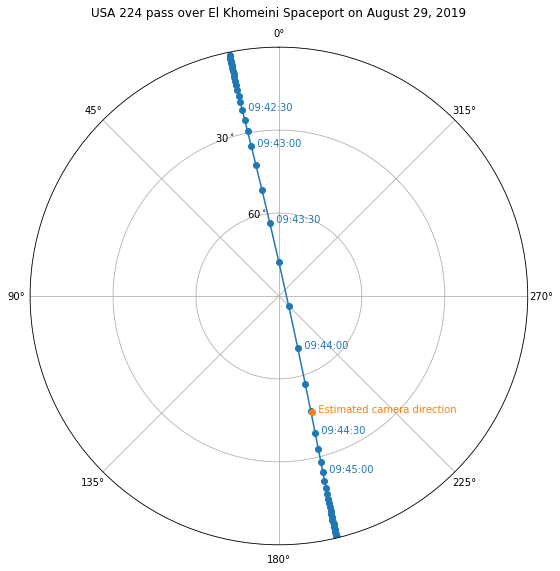

In [14]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='polar')
ax.set_theta_offset(np.pi/2.0)
#ax.set_theta_direction(-1)
ax.plot(az, za)
ax.plot(az, za, "C0o")
ax.set_rticks([90, 60, 30, 0])
ax.set_rgrids([90, 60, 30, 0], ["", "30$^\circ$", "60$^\circ$", ""])
ax.plot(azimuth*np.pi/180.0, 90-elevation, "o")
ax.text(azimuth*np.pi/180.0, 90-elevation, "  Estimated camera direction", color="C1")
for i in range(0, len(az), 3):
    if za[i]<70.0:
        ax.text(az[i], za[i], "  %s" % times[i], color="C0")
ax.grid(True)
ax.bar(0, 90).remove()
ax.set_rmax(90.0)
ax.set_title("USA 224 pass over El Khomeini Spaceport on August 29, 2019")

plt.tight_layout()
plt.savefig("usa224_pass.png", bbox_inches="tight")

In [15]:
for i in range(len(times)):
    if "09:44:20" in times[i]:
        print("Distance at %s: %.1f km" %(times[i], dist[i]/1000))

Distance at 09:44:20: 382.1 km


USA 224 passed very close to the camera direction at 09:44:20UTC on August 29, 2019. At that time, USA 224 was at a distance of 382 km from El Khomeini Spaceport.